In [1]:
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

import add_path
from toolkit import paths
from toolkit.allen_helpers.location import CCF_COORDS
from toolkit.plots.plots import plot_probe_channel_positions
from toolkit.allen_helpers.location import fill_missing_linear_channels, StructureFinder, central_channel_in_structure
from toolkit.analysis.signal import compute_csd
from toolkit.pipeline.data_io import SessionDirectory

pd.set_option('display.max_columns', None)

with open('config.json') as f:
    config = json.load(f)

## Get session and probe

In [3]:
session_id = config['session_id']
ecephys_structure_acronym = config['ecephys_structure_acronym']
print(f"Session ID: {session_id}")

Session ID: 732592105


In [2]:
# Cache directory path, it determines where downloaded data will be stored
# Cache directory will be created if it doesn't exist
cache = EcephysProjectCache.from_warehouse(manifest=paths.ECEPHYS_MANIFEST_FILE)

In [4]:
# get channels in the structure
session = cache.get_session_data(session_id)
all_channels = session.channels
channels = all_channels.loc[all_channels['structure_acronym'] == ecephys_structure_acronym]

/home/zc963/anaconda3/envs/allen/lib/python3.10/site-packages/hdmf/spec/namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [5]:
# get probes for the session and structure (usually only one)
no_lfp_error = None
probes = cache.get_probes()
probes = probes[probes['ecephys_session_id'] == session_id]
probes = probes.iloc[
    [ecephys_structure_acronym in x for x in probes['ecephys_structure_acronyms']]
]

if not len(probes):
    no_lfp_error = ValueError(f"No probes containing {ecephys_structure_acronym} found for session {session_id}")

# check if the probes have lfp data
if not no_lfp_error and not any(probes['has_lfp_data']):
    no_lfp_error = ValueError(f"Probe {', '.join(map(str, probes.index))} has no LFP data")
probes = probes[probes['has_lfp_data']]

In [6]:
if not no_lfp_error:
    # get the probe with the most channels in the structure
    n_channels_in_probe =  [np.count_nonzero(channels['probe_id'] == i) for i in probes.index]
    probe_id = probes.index[np.argmax(n_channels_in_probe)]
    fs = probes.loc[probe_id, 'lfp_sampling_rate']

    # Load LFP given probe
    lfp_array = session.get_lfp(probe_id)
    lfp_array.attrs.update(fs=fs)

    # check if the LFP data has missing time durations
    missing_time_points = np.count_nonzero(lfp_array.time < 0)
    start_time = lfp_array.time[0].item()
    print(f"LFP data starts at {start_time:.2f} seconds")
    if missing_time_points > 1:
        missing_time_durations = missing_time_points / fs + start_time
        no_lfp_error = ValueError(f"LFP in probe {probe_id} has missing time durations: ~{missing_time_durations:.2f} seconds.")

/home/zc963/anaconda3/envs/allen/lib/python3.10/site-packages/hdmf/spec/namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
/home/zc963/anaconda3/envs/allen/lib/python3.10/site-packages/hdmf/spec/namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
/home/zc963/anaconda3/envs/allen/l

LFP data starts at 0.53 seconds


Number of channels: 78
Number of missing channels in middle: 2
Vertical range: 780 μm
Number of rows: 40


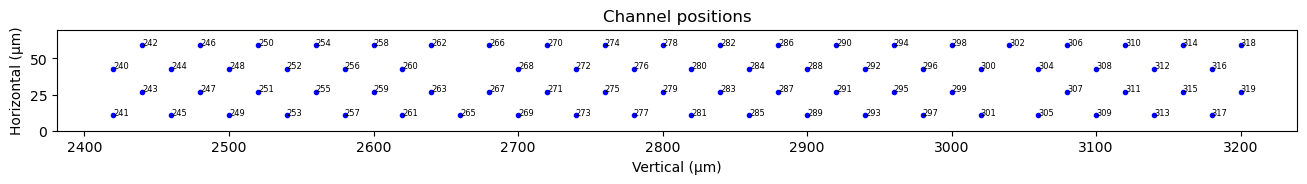

In [7]:
if not no_lfp_error:
    # overview of channels layout in the structure
    vertical_position_range = channels['probe_vertical_position'].max() - channels['probe_vertical_position'].min()
    n_missing_channels = channels['probe_channel_number'].max() - channels['probe_channel_number'].min() + 1 - len(channels)
    print(f"Number of channels: {len(channels):d}")
    print(f"Number of missing channels in middle: {n_missing_channels:d}")
    print(f"Vertical range: {vertical_position_range:d} μm")
    print(f"Number of rows: {vertical_position_range // 20 + 1:d}")

    plot_probe_channel_positions(channels)
    plt.show()

In [8]:
if no_lfp_error:  # save null probe info and raise error
    session_dir = SessionDirectory(session_id, ecephys_structure_acronym)
    session_dir.save_null_probe_info()
    raise no_lfp_error

### Find LFP channels locations in structure

In [9]:
# channels in the probe sorted by probe_channel_number
probe_channels = all_channels.loc[all_channels['probe_id'] == probe_id].sort_values('probe_channel_number')

# fill possible missing channels
probe_channels = fill_missing_linear_channels(probe_channels, lfp_array.channel)

# get channels in the structure in the probe
channels = probe_channels.loc[probe_channels['structure_acronym'] == ecephys_structure_acronym]

# Ensure channels are sorted by vertical position
channel_idx = np.argsort(probe_channels.loc[lfp_array.channel, 'probe_vertical_position'])
if not np.all(np.diff(channel_idx) == 1):
    lfp_array = lfp_array.isel(channel=channel_idx)

In [10]:
# get LFP channels in the structure
channel_idx = np.nonzero([i in channels.index for i in lfp_array.channel.values])[0]
channel_idx_csd = np.copy(channel_idx)  # channel indices for CSD

padding = [1, 1]  # replicate padding for iCSD boundaries
if channel_idx[0] > 0:
    padding[0] = 0  # no padding if a leading channel exists
    channel_idx_csd = np.insert(channel_idx_csd, 0, channel_idx[0] - 1)
if channel_idx[-1] < lfp_array.channel.size - 1:
    padding[1] = 0  # no padding if a trailing channel exists
    channel_idx_csd = np.append(channel_idx_csd, channel_idx[-1] + 1)

channels_id = lfp_array.channel[channel_idx]
channels_id_csd = lfp_array.channel[channel_idx_csd]

csd_channel_positions = probe_channels.loc[channels_id_csd, 'probe_vertical_position']

# validate if the spacing between LFP channels is consistent
if np.unique(np.diff(csd_channel_positions)).size != 1:
    raise ValueError('The spacing between LFP channels is not consistent')

In [11]:
# Get dataframe for LFP channels in the structure and get layer of each channel
lfp_channels = channels.loc[channels_id]
sf = StructureFinder(paths.REFERENCE_SPACE_CACHE_DIR, structure_acronym=ecephys_structure_acronym)
lfp_channels['layer_acronym'], lfp_channels['inside_structure'] = \
    sf.get_structure_array(lfp_channels[CCF_COORDS])

In [12]:
# Get central channels in each layer
valid_channels = lfp_channels.loc[lfp_channels['inside_structure']]
central_channels = central_channel_in_structure(valid_channels['layer_acronym'])
central_channels = {s: int(valid_channels.index[i]) for s, i in central_channels.items()}

In [13]:
# Select channels for CSD
csd_array = compute_csd(
    lfp=lfp_array.sel(channel=channels_id_csd),
    positions=csd_channel_positions,
    sigma_time=1.6,
    sigma_space=40.0,
    padding=padding
)

/home/group/Analyzing_Allen_Visual_Coding_Neuropixels_Dataset/notebooks/../toolkit/utils/quantity_units.py:111: UserWarning: DataArray has no attribute 'unit', assuming unit 'V/µm²'
  warnings.warn(f"DataArray has no attribute 'unit', assuming unit '{as_unicode(src_unit)}'")


## Save data

In [14]:
# Get session cache directory
session_dir = SessionDirectory(session_id, ecephys_structure_acronym)

# Save probe info
session_dir.save_probe_info(probe_id, central_channels, channels_id_csd, padding)

# Save LFP channels info
session_dir.save_lfp_channels(lfp_channels)

# Save CSD
session_dir.save_csd(csd_array)